# Práctica: detección de fraude mediante métodos de ensembles

ESTUDIANTES: `ESCRIBID VUESTROS NOMBRES AQUI`

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/fraud.jpg" style="width:600px;">

En esta práctica vamos a utilizar todos los conocimientos adquiridos en los ejercicios anteriores, con el objetivo de construir un detector automático de fraude en pagos bancarios.

## Instrucciones

A lo largo del notebook encontrarás celdas que debes rellenar con tu propio código. Sigue las instrucciones del notebook y presta atención a los siguientes iconos:

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Deberás resolver el ejercicio escribiendo tu propio código o respuesta en la celda inmediatamente inferior.
    <b>La nota máxima que puede obtenerse con esta clase de ejercicios es de 7 sobre 10.</b>
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
Esto es una pista u observación de utilidad que puede ayudarte a resolver el ejercicio. Presta atención a estas pistas para comprender el ejercicio en mayor profundidad.
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/pro.png" height="80" width="80" style="float: right;"/>

***
<font color=#259b4c>
Este es un ejercicio avanzado que te puede ayudar a profundizar en el tema, y a conseguir una calificación más alta. <b>Resolviendo esta clase de ejercicios puedes llegar conseguir hasta 3 puntos sobre 10.</b> ¡Buena suerte!</font>

***

Para evitar problemas con imports o incompatibilidades se recomienda ejecutar este notebook en uno de los [entornos de Ensembles recomendados](https://github.com/albarji/teaching-environments-ensembles).

El siguiente código mostrará todas las gráficas en el propio notebook en lugar de generar una nueva ventana.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Finalmente, si necesitas ayuda en el uso de cualquier función Python, coloca el cursor sobre su nombre y presiona Shift+Tab. Aparecerá una ventana con su documentación. Esto solo funciona dentro de celdas de código.

¡Vamos alla!

## Carga de datos

Los datos para este problema están incluidos en la carpeta *data*, con ficheros separados para entrenamiento y test. Cada fichero incluye varias variables explicativas no identificadas, junto con una variable `Amount` que indica el importe de la operación, y la variable objetivo `Class`. Las operaciones fraudulentas son aquellas marcadas con `Class == 1`.

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Carga los datos de entrenamiento y test en sendos Pandas DataFrames con nombres <b>train</b> y <b>test</b>, respectivamente.
</font>

***

In [3]:
import pandas as pd
import numpy as np
train = pd.read_csv("./data/fraud_train.csv")
test = pd.read_csv("./data/fraud_test.csv")

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Realiza un análisis mínimo de los datos de entrenamiento para contestar las siguientes preguntas: ¿cuántas variables explicativas hay? ¿Cuál es la distribución de las clases?
</font>

***

In [20]:
print(f'Columnas: {train.columns}')
# train.describe().transpose()
train.Class.value_counts()

Columnas: Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')


0    5000
1     246
Name: Class, dtype: int64

## Midiendo el rendimiento de un detector de fraude

Las actividades fraudulentas son constantemente perseguidas, por lo que los defraudadores necesitan ser creativos e inventar nuevas formas de llevar a cabo sus fraudes. Además, afortunadamente, las operaciones fraudulentas son relativamente escasas, lo que nos lleva a contar con pocos casos positivos para entrenar el modelo. Dicho de otro modo, nos enfrentamos a un problema altamente desequilibrado, lo cual dificulta el entrenamiento del modelo, así como su evaluación.

Consideremos un modelo trivial que clasifica todos los casos como negativos (operaciones legítimas). Podemos simular las predicciones de este modelo creando un vector de predicciones de todo ceros:

In [5]:
dumbpreds = [0] * len(test)

Midamos el porcentaje de acierto de este modelo sobre el conjunto de test

In [6]:
from sklearn.metrics import accuracy_score

accuracy_score(test["Class"], dumbpreds)

0.9531071292413267

Deberías haber obtenido en torno a un 95% de acierto, ya que la gran mayoría de casos son negativos. A pesar de eso, ¡este modelo es totalmente inútil como detector de fraudes! Por tanto, necesitamos una métrica mejor.

Una métrica que funciona bien para problemas muy desbalanceados es el [área bajo la curva ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic), o AUC. En scikit-learn esta métrica está disponible, y podemos probarla para comprobar que el rendimiento de este modelo es realmente malo

In [7]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay, roc_curve, auc

roc_auc_score(test["Class"], dumbpreds)

0.5

Un AUC del 50% indica que el modelo no es mejor que lanzar predicciones aleatoriamente. Si evaluáramos un modelo en el que las predicciones de probabilidad de la clase fraude fueran algo más altas para los casos realmente fraudulentos que para los casos legítimos, veríamos cómo el AUC produce mayores valores. El caso óptimo para esta métrica es un modelo en el que todos los casos de fraude son predichos con una mayor probabilidad de fraude que todos los casos de operaciones legítimas.

## Detector de fraude no supervisado

Dado que apenas tenemos datos de fraude, puede tener sentido empezar construyendo un modelo no supervisado.


<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
    Usando <b>solo los datos de train</b>, y sin emplear la variable <i>Class</i>, construye un modelo de tipo IsolationForest para detección de anomalías. Mide el rendimiento del modelo sobre el conjunto de test, usando la métrica AUC.
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
Ten en cuenta los siguientes puntos para construir un buen modelo:
    <ul>
        <li>Puedes estimar el parámetro <i>contamination</i> como la proporción de datos fraudulentos del conjunto de entrenamiento.</li>
        <li>Por defecto IsolationForest emplea pocos árboles. Asegúrate de probar con diferentes números de árboles.</li>
        <li>La métrica AUC necesita recibir las <b>probabilidades de clase fraude</b> para funcionar correctamente. No es posible obtener probabilidades de un IsolationForest, pero puedes hacer uso de su función <i>decision_function</i> para obtener scores normalizados (profundidades medias en el árbol), las cuales pueden ser negadas para obtener valores que pueden interpretarse como probabilidades de clase fraude (no normalizadas).</li>
    </ul>
    Si has entrenado el modelo correctamente, deberías obtener en torno a un <b>94% de AUC</b>.
</font>

***

In [15]:
from sklearn.ensemble import IsolationForest

features = [col for col in train.columns if col != 'Class']
Xtrain = train[features].values
Xtest = test[features].values

percent_fraude = sum(train.Class == 1)/train.shape[0]

for n in [10, 100, 500, 1000]:
    isoforest = IsolationForest(n_estimators=n, contamination=percent_fraude)

    isoforest.fit(Xtrain)
    negative_depth = np.negative(isoforest.decision_function(Xtest))

    print(f'AUC con {n} árboles: {roc_auc_score(test["Class"], negative_depth)}')


AUC para 10 árboles: 0.8843373983739837
AUC para 100 árboles: 0.9455569105691057
AUC para 500 árboles: 0.9473577235772358
AUC para 1000 árboles: 0.9430796747967479


<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
    Crea una visualización mostrando el rendimiento de este modelo sobre los datos de test.
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
Sugerencia: utiliza <a href=https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html>visualización ROC que se presenta en la documentación de scikit-learn</a>.
</font>

***

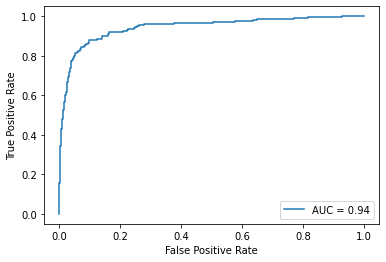

In [16]:
fpr, tpr, thresholds = roc_curve(test['Class'], negative_depth)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()

## Árbol de detección de fraude

Ahora vamos a comprobar si un método supervisado sencillo e interpretable, como es un árbol de decisión, puede ayudarnos a resolver este problema.

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
    Entrena un árbol de decisión sobre los datos de train, haciendo uso tanto de las variables explicativas como de la variable objetivo. Trata de que el árbol sea sencillo, de forma que puedas generar una visualización interpretable del mismo. Mide también los resultados del árbol en AUC sobre el conjunto de test. ¿Obtienes mejoras sobre el modelo no supervisado?
</font>

***

In [10]:
####### INSERT YOUR CODE HERE

## Modelos supervisados de ensemble

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
    Vamos a comprobar cómo es posible mejorar los resultados de detección usando métodos de ensemble. Entrena <b>al menos 5 de los métodos de ensemble vistos en clase</b>, y mide sus resultados de AUC en el test.
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
Algunas sugerencias de modelos disponibles en scikit-learn que puedes utilizar:
    <ul>
        <li>Random Forest</li>
        <li>Extra Trees</li>
        <li>AdaBoost</li>
        <li>Gradient Boosting</li>
        <li>Bagging</li>
        <li>Voting</li>
        <li>Stacking</li>
    </ul>
No olvides que para medir correctamente el AUC, debes suministrar a esta métrica las <b>probabilidades de clase fraude</b> predichas por el modelo, las cuales puedes obtener mediante el método <i>predict_proba</i>.
    
Si has entrenado los modelos correctamente, tu mejor resultado debería ser de al menos un <b>97% de AUC</b> en test.
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/pro.png" height="80" width="80" style="float: right;"/>

***
<font color=#259b4c>
Adicionalmente, se valorará:
    <ul>
        <li>Utilizar más técnicas de ensembles, además de las 5 mínimas requeridas</li>
        <li>Mejorar el AUC en test de tu modelo lo máximo posible</li>
        <li>Utilizar <a href=https://catboost.ai/>CatBoost</a> y/o <a href=https://lightgbm.readthedocs.io/en/latest/>LightGBM</a>, otras librerías de ensemble muy efectivas. Nótese que deberás instalar estas librerías en el entorno.</li>
    </ul>
</font>

***

In [11]:
####### INSERT YOUR CODE HERE

## Visualización

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
    Crea una visualización mostrando el rendimiento de todos tus modelos supervisados sobre el conjunto de test, junto con el modelo no supervisado. La visualización debe mostrar claramente cuál es el modelo con mayor AUC.
</font>

***

In [12]:
####### INSERT YOUR CODE HERE